In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('mock_data.csv')

- $P(L_i|\alpha, S, M_i, z_i); M_i \sim P(M_i), z_i \sim data$
- $data$
- draw from Q

In [3]:
data.columns

Index([u'Unnamed: 0', u'gal_id', u'z', u'mass_h', u'ra', u'dec', u'lum',
       u'lum_obs'],
      dtype='object')

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# normal distribution center at x=0 and y=5
x = np.log(data.mass_h) / np.log(10)
y = np.log(data.lum) / np.log(10)
z = np.log(data.lum_obs)/np.log(10)

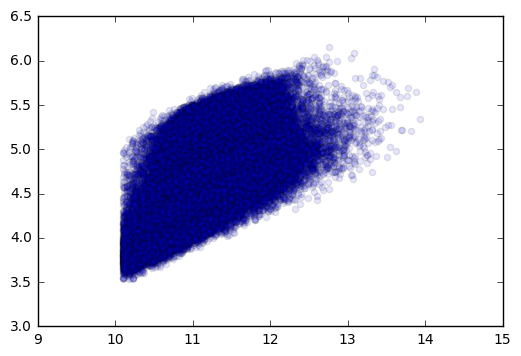

In [5]:
plt.scatter(x, y, alpha=.1)

In [6]:
import hmf
import scipy.interpolate as interpolate

class MassPrior():
    """
    Class to represent mass prior distribution.
    Initialize with mass and probability arrays.
    Can both evaluate and sample from distribution.
    """
    def __init__(self, mass, prob):
        self.mass = mass
        self.prob = prob
        self.min = mass.min()
        self.max = mass.max()
        # have to add 0,1 samples for interpolation bounds
        cumsum = np.append(np.append(np.array([0]), np.cumsum(prob)), np.array([1]))
        masses = np.append(np.append(np.array([self.min-1]), self.mass), np.array([self.max+1]))
        self.inv_cdf = interpolate.interp1d(cumsum, masses)

        
    def pdf(self, mass):
        if np.any(mass < self.min) or np.any(mass > self.max):
            raise Exception('out of range')
        right_ind = np.searchsorted(self.mass, mass)
        left_ind = right_ind - 1
        # find where we fall in interval between masses
        f = (mass - self.mass[left_ind]) / (self.mass[right_ind] - self.mass[left_ind])
        return f * self.prob[right_ind] + (1-f) * self.prob[left_ind]
        
    def rvs(self, size=1):
        return self.inv_cdf(np.random.rand(size))
    
    @staticmethod
    def default():
        h = 0.73
        Mmin = 10.2358590918
        Mmax = 14.3277327776
        mf = hmf.MassFunction(Mmin=Mmin, Mmax=Mmax, cosmo_model=hmf.cosmo.WMAP5, hmf_model=hmf.fitting_functions.Tinker10)
        return MassPrior(mf.m*h, mf.dndm / sum(mf.dndm))    

In [7]:
#fix hyperparameters
from scipy.stats import norm

np.random.seed(1)

alpha1 = norm(10.709, 0.022).rvs()
alpha2 = norm(0.359, 0.009).rvs()
alpha3 = 2.35e14
alpha4 = norm(1.10, 0.06).rvs()
S = norm(0.155, 0.0009).rvs()
sigma_L = 0.05

np.random.seed(2)

alpha1b = norm(10.709, 0.022).rvs()
alpha2b = norm(0.359, 0.009).rvs()
alpha3b = 2.35e14
alpha4b = norm(1.10, 0.06).rvs()
Sb = norm(0.155, 0.0009).rvs()
sigma_Lb = 0.05

In [20]:
from scipy.stats import lognorm

lolo = lognorm(sigma_L, scale=data.lum_obs).rvs()

z = data.z
mu_l = np.exp(alpha1 + alpha2 * np.log(data.mass_h / alpha3) + alpha4*np.log(1+z))
mu_m = alpha3 * (lolo / (np.exp(alpha1) * (1 + z) ** alpha4)) ** (1 / alpha2)


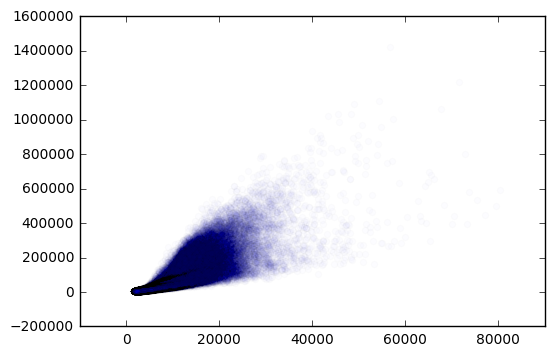

In [24]:
plt.scatter(mu_l, data.lum, alpha=0.01)

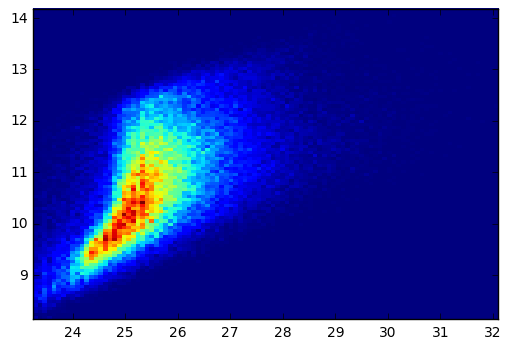

In [31]:
plt.hist2d(np.log(data.mass_h), np.log(data.lum), bins=100, );

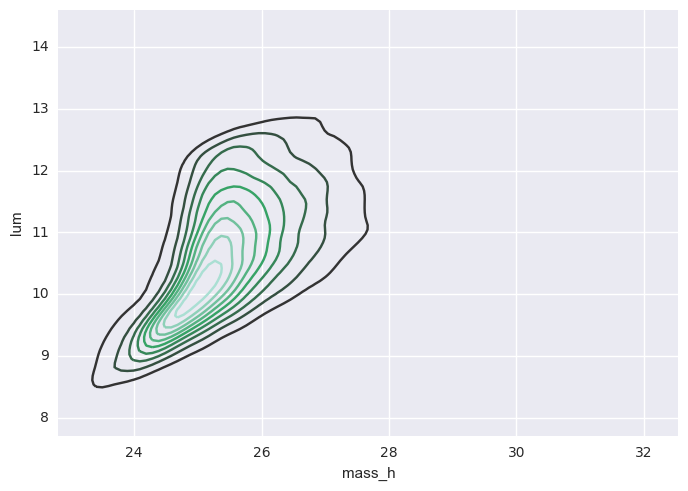

In [32]:
import seaborn as sns

sns.kdeplot(np.log(data.mass_h), data2=np.log(data.lum))

In [43]:
from scipy.stats import lognorm

def log10(arr):
    return np.log(arr) / np.log(10.)

mass_prior = MassPrior.default()
n = len(data)

# Generate True (M,L)
def generate_truth():
    return log10(data.mass_h), log10(data.lum)

# Generate P(M,L)
def generate_p():
    m = mass_prior.rvs(size=n)
    z = data.z
    mu_l = np.exp(alpha1b + alpha2b * np.log(m_p / alpha3b) + alpha4b * (1+z))
    l = lognorm(Sb, scale=mu_l).rvs(size=n)
    return log10(m), log10(l)

# Generate Q(M,L)
def generate_q():
    lobs = data.lum_obs
    l = lognorm(sigma_Lb, loc=lobs).rvs(n)
    z = data.z
    mu_m = alpha3b * (l / (np.exp(alpha1b) * (1 + z) ** alpha4b)) ** (1 / alpha2b)
    m = lognorm(Sb, loc=mu_m).rvs(n)
    return log10(m), log10(l)

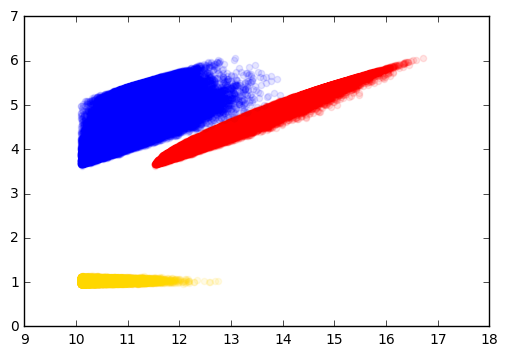

In [40]:
plt.scatter(*generate_truth() , alpha=0.1, color='blue')
plt.scatter(*generate_q() , alpha=0.1, color='red')
plt.scatter(*generate_p() , alpha=0.1, color='gold')

In [26]:
generate_truth()

NameError: name 'generate_truth' is not defined

In [44]:
def generate_qprime():
    np.random.seed(1)

    alpha1 = norm(10.709, 0.022).rvs()
    alpha2 = norm(0.359, 0.009).rvs()
    alpha3 = 2.35e14
    alpha4 = norm(1.10, 0.06).rvs()
    S = norm(0.155, 0.0009).rvs()
    sigma_L = 0.05

    lobs = data.lum_obs
    l = lognorm(sigma_Lb, loc=lobs).rvs(n)
    z = data.z
    mu_m = alpha3 * (l / (np.exp(alpha1) * (1 + z) ** alpha4)) ** (1 / alpha2)
    m = lognorm(S, loc=mu_m).rvs(n)
    return log10(m), log10(l)

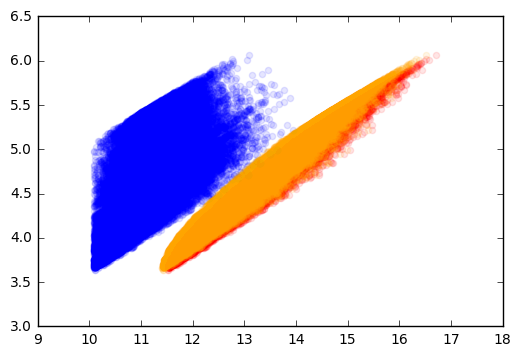

In [46]:
plt.scatter(*generate_truth() , alpha=0.1, color='blue')
plt.scatter(*generate_q() , alpha=0.1, color='red')
plt.scatter(*generate_qprime() , alpha=0.1, color='orange')

(array([  3.,  12.,  23.,  22.,   9.,  12.,  11.,   3.,   1.,   4.]),
 array([ 2.31711665,  2.33992201,  2.36272738,  2.38553274,  2.4083381 ,
         2.43114346,  2.45394882,  2.47675419,  2.49955955,  2.52236491,
         2.54517027]),
 <a list of 10 Patch objects>)

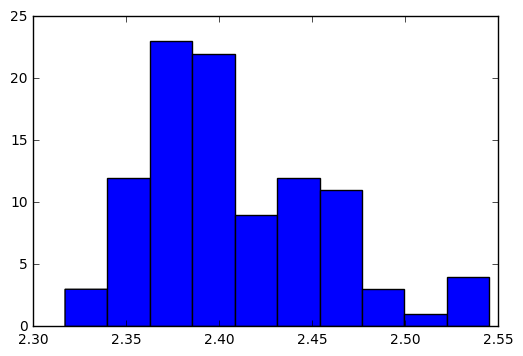

In [51]:
plt.hist(np.log(lognorm(0.5, loc=10).rvs(100)))

In [60]:
l0 = 20
li = 22
sigmal = 5
from math import sqrt
val = (1 / sqrt(li**2 * 2 * np.pi * sigmal ** 2)) * np.exp(- (np.log(li) - np.log(l0)) / (2*sigmal ** 2))

In [62]:
lognorm(sigmal, loc=20).pdf(22)

0.039512717910589024

In [61]:
val

0.003619841268475811

In [69]:
def foo(x,s):
    return 1/(s*x*sqrt(2*np.pi)) * np.exp(-1/2*(np.log(x)/s)**2)

In [70]:
lognorm.pdf(1,3)

0.13298076013381091

In [71]:
foo(1,3)

0.13298076013381091

(array([   1.,   16.,   61.,  149.,  265.,  272.,  165.,   56.,   11.,    4.]),
 array([  6.54004984,   7.24265473,   7.94525961,   8.6478645 ,
          9.35046939,  10.05307428,  10.75567916,  11.45828405,
         12.16088894,  12.86349382,  13.56609871]),
 <a list of 10 Patch objects>)

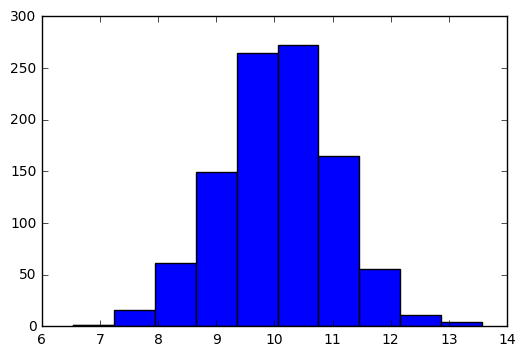

In [78]:
plt.hist(np.log(lognorm(s=1, scale=np.exp(10)).rvs(1000)))